In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# Reverse Mode Automatic Differentiation

We demonstrate reverse mode AD with the function
$$ f(x_1, x_2) = \sin(x_1 + x_2) \cdot \cos(x_1 - x_2) + (x_1 + x_2) \cdot (x_1 - x_2) $$
To compute the function step by step, we introduce the following auxiliary variables:
* $v_1 := x_1 + x_2$,
* $v_2 := x_1 - x_2$,
* $v_3 := \sin(v_1)$,
* $v_4 := \cos(v_2)$,
* $v_5 := v_3 \cdot v_4$,
* $v_6 := v_1 \cdot v_2$,
* $y   := v_5 + v_6$.

In [2]:
def f(x1, x2):
    return sin(x1 + x2) * cos(x1 - x2) + (x1 + x2) * (x1 - x2)

The computational graph `GC` defined below implements the function `f` that is defined above.

In [3]:
CG = [ ('x1', ),
       ('x2', ),
       ('v1', '+',   'x1', 'x2'),
       ('v2', '-',   'x1', 'x2'),
       ('v3', 'sin', 'v1'),
       ('v4', 'cos', 'v2'),
       ('v5', '*',   'v3', 'v4'),
       ('v6', '*',   'v1', 'v2'),
       ('y',  '+',   'v5', 'v6')
     ]

In [4]:
import graphviz as gv

The function `render(CG)` takes a computational graph `CG` as input and renders it graphically via `graphviz`.

In [5]:
def render(CG):
    cg = gv.Digraph()
    cg.attr(rankdir='LR', splines='false')
    for node in CG:
        shape = 'rectangle'
        match node:
            case (v, ):
                label = f'{v}'
                shape = 'circle'
            case (v, r):
                label = f'{v} := {r}'
            case (v, op, a1, a2):
                label = f'{v} := {a1} {op} {a2}'
            case (v, f, a):
                label = f'{v} :=  {f}({a})'
        cg.node(v, label=label, shape=shape)
    for node in CG:
        match node:
            case (v, _, a1, a2):
                cg.edge(a1, v)
                cg.edge(a2, v)
            case (v, _, a):
                cg.edge(a, v)
    return cg

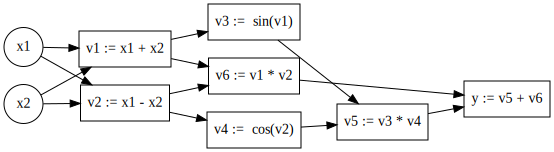

In [6]:
dot = render(CG)
dot

In [7]:
dot.save(filename='cg.dot')

'cg.dot'

In [8]:
import math

The function `eval_graph` takes two arguments:
* `CG` is a computational graph,
* `Values` is a dictionary assigning values to variable names.

In [9]:
def eval_graph(CG, Values):
    for node in CG:
        match node:
            case (v, ):
                pass
            case (v, r):
                Values[v] = r
            case (v, '+', a1, a2):
                Values[v] = Values[a1] + Values[a2]
            case (v, '-', a1, a2):
                Values[v] = Values[a1] - Values[a2]
            case (v, '*', a1, a2):
                Values[v] = Values[a1] * Values[a2]
            case (v, '/', a1, a2):
                Values[v] = Values[a1] / Values[a2]
            case (v, 'sqrt', a):
                Values[v] = math.sqrt(Values[a])            
            case (v, 'exp', a):
                Values[v] = math.exp(Values[a])
            case (v, 'log', a):
                Values[v] = math.log(Values[a])
            case (v, 'sin', a):
                Values[v] = math.sin(Values[a])
            case (v, 'cos', a):
                Values[v] = math.cos(Values[a])
            case (v, 'atan', a):
                Values[v] = math.atan(Values[a])
            case (v, r):
                Values[v] = r
    return Values['y']

In [10]:
import math

In [11]:
eval_graph(CG, { 'x1': math.pi/4, 'x2': math.pi/4 })

1.0

In [12]:
def add_to_dictionary(D, key, value):
    if key in D:
        D[key] |= { value }
    else:
        D[key]  = { value }

Given a *computational graph* `CG`, the function `parents` returns a dictionary `Parents` such that
for every node name `n` occurring in `CG` we have that `Parents[n]` is the set of nodes that are parents 
of the node labeled with `n`. 

In [13]:
def parents(CG):
    Parents = {}
    for node in CG:
        match node:
            case (p, _, a):
                add_to_dictionary(Parents, a, p)
            case (p, _, a1, a2):
                add_to_dictionary(Parents, a1, p)
                add_to_dictionary(Parents, a2, p)
    return Parents

In [14]:
parents(CG)

{'x1': {'v1', 'v2'},
 'x2': {'v1', 'v2'},
 'v1': {'v3', 'v6'},
 'v2': {'v4', 'v6'},
 'v3': {'v5'},
 'v4': {'v5'},
 'v5': {'y'},
 'v6': {'y'}}

In [15]:
def node_dictionary(CG):
    D = {}
    for node in CG:
        name    = node[0]
        D[name] = node
    return D

In [16]:
node_dictionary(CG)

{'x1': ('x1',),
 'x2': ('x2',),
 'v1': ('v1', '+', 'x1', 'x2'),
 'v2': ('v2', '-', 'x1', 'x2'),
 'v3': ('v3', 'sin', 'v1'),
 'v4': ('v4', 'cos', 'v2'),
 'v5': ('v5', '*', 'v3', 'v4'),
 'v6': ('v6', '*', 'v1', 'v2'),
 'y': ('y', '+', 'v5', 'v6')}

The function `partial_derivative` takes three arguments:
* `Node` is a computational node,
* `arg` is the name of a node occurring as argument in `Node`, 
* `Values` is a dictionary that stores a value for every node name.

The function computes the partial derivative of `Node` w.r.t. `arg`.

In [17]:
def partial_derivative(Node, arg, Values):
    result = 0
    match Node:
        case n, '+', a1, a2:
            if arg == a1 == a2:
                return 2
            if arg == a1 or arg == a2:
                return 1
            else:
                assert False, f'partial_derivative({Node}, {arg})'
        case n, '-', a1, a2:
            if arg == a1 == a2:
                return 0
            if arg == a1:
                return 1
            if arg == a2:
                return -1
            else:
                assert False, f'partial_derivative({Node}, {arg})'
        case n, '*', a1, a2:
            if arg == a1 == a2:
                return 2 * Values[a1]
            if arg == a1:
                return Values[a2]
            if arg == a2:
                return Values[a1]
            else:
                assert False, f'partial_derivative({Node}, {arg})'
        case n, '/', a1, a2:
            if arg == a1 == a2:
                return 0
            if arg == a1:
                return 1 / Values[a2]
            if arg == a2:
                return -Values[a1] / Values[a2] ** 2
            else:
                assert False, f'partial_derivative({Node}, {arg})'
        case n, 'exp', a:
            return math.exp(Values[a])
        case n, 'log', a:
            return math.log(Values[a])
        case n, 'sin', a:
            return math.cos(Values[a])
        case n, 'cos', a:
            return -math.sin(Values[a])
        case n, 'atan', a:
            return 1 / (1 + Values[a]**2)
    return result

In [20]:
def adjoints(CG, Values):
    eval_graph(CG, Values)
    NodeDict = node_dictionary(CG)
    Parents  = parents(CG)
    n        = len(CG)
    Adjoints = {}
    Adjoints['y'] = 1
    for k in range(2, n+1):
        Node   = CG[-k]
        name   = Node[0]
        result = 0
        for parent_name in Parents[name]:
            parent_node = NodeDict[parent_name]
            result += Adjoints[parent_name] * partial_derivative(parent_node, name, Values)
        Adjoints[name] = result
    return Adjoints

In [21]:
adjoints(CG, { 'x1': math.pi/4, 'x2': math.pi/4 })

{'y': 1,
 'v6': 1,
 'v5': 1,
 'v4': 1.0,
 'v3': 1.0,
 'v2': 1.5707963267948966,
 'v1': 6.123233995736766e-17,
 'x2': -1.5707963267948966,
 'x1': 1.5707963267948966}

In [ ]:
CG